In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import multiprocess      as mp
import pandas            as pd

from libraries                         import utils
from pymatgen.analysis.phase_diagram   import PhaseDiagram
from pymatgen.entries.computed_entries import ComputedEntry
from os                                import path
from sklearn                           import model_selection
from sklearn.ensemble                  import RandomForestRegressor
from sklearn.neural_network            import MLPRegressor
from sklearn.model_selection           import ShuffleSplit

sns.set_theme()

Defining general output properties

In [2]:
linewidth      = 0.5
footnotesize   = 8
s_footnotesize = 10*0.8
eps_dpi        = 100
png_dpi        = 400
output_folder  = 'output/ternary_chalcohalides'
input_folder   = 'input/ternary_chalcohalides'

# Iterations might be run from here

In [3]:
vbm     = np.loadtxt(f'{input_folder}/results_vbm.txt')
bandgap = np.loadtxt(f'{input_folder}/results_bandgap.txt')

In [4]:
# Convert the array to a Pandas DataFrame
vbmd = pd.DataFrame(vbm, columns=["x", "y", "z", "vbm"])
vbmd.set_index(["x", "y", "z"], inplace=True)

bandgapd = pd.DataFrame(bandgap, columns=["x", "y", "z", "bandgap"])
bandgapd.set_index(["x", "y", "z"], inplace=True)

# Combine the DataFrames, aligning by index
data = pd.concat([vbmd, bandgapd], axis=1)

data['cbm'] = data['vbm'] + data['bandgap']
data

vbm   bandgap       cbm
x   y   z                                 
0.0 0.0 0.00 -6.257629  1.499756 -4.757873
        0.05 -6.269038  1.510627 -4.758411
        0.10 -6.281808  1.522710 -4.759099
        0.15 -6.294027  1.534460 -4.759567
        0.20 -6.302869  1.543422 -4.759447
...                ...       ...       ...
1.0 1.0 0.80 -6.734043  1.589224 -5.144819
        0.85 -6.709891  1.568368 -5.141523
        0.90 -6.683843  1.544777 -5.139066
        0.95 -6.656143  1.520975 -5.135168
        1.00 -6.629665  1.497793 -5.131872

[1804 rows x 3 columns]

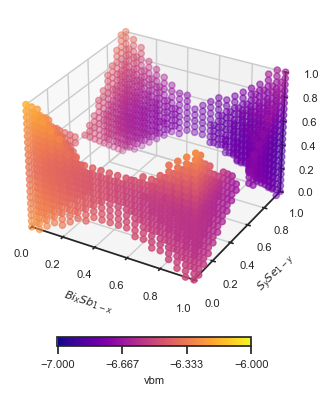

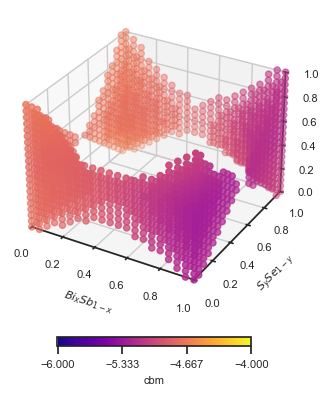

In [5]:
valid_xyz = np.array(data.index.to_frame(index=False).values)

for target in ['vbm', 'cbm']:
    valid_pred = data[target].values
    bar_name = target
    sns.set_theme(style='white')

    fig = plt.figure(figsize=(5, 5))
    ax  = plt.axes(projection='3d')

    # Setting minimum and maximum values for the colorbar
    vmin = np.floor(np.min(valid_pred))
    vmax = np.ceil(np.max(valid_pred))

    # Plotting valid points
    sc = ax.scatter(valid_xyz[:, 0],
                    valid_xyz[:, 1],
                    valid_xyz[:, 2],
                    c=valid_pred,
                    vmin=vmin, vmax=vmax,
                    marker='o', cmap='plasma')

    # Bar
    cbar = fig.colorbar(sc, orientation='horizontal', location='bottom',
                        pad=0.1, shrink=0.5, ticks=np.linspace(vmin, vmax, 4))

    # Defining bar
    cbar.ax.tick_params(labelsize=footnotesize)
    cbar.set_label(bar_name, fontsize=footnotesize)

    # Setting labels
    ax.set_xlabel(r'$Bi_x Sb_{1-x}$',  fontsize=footnotesize)
    ax.set_ylabel(r'$S_y Se_{1-y}$',  fontsize=footnotesize)
    ax.set_zlabel(r'$I_z Br_{1-z}$',  fontsize=footnotesize)

    # Setting number to scale
    ax.tick_params(axis='x', labelsize=footnotesize)
    ax.tick_params(axis='y', labelsize=footnotesize)
    ax.tick_params(axis='z', labelsize=footnotesize)

    # Setting limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Saving the figure
    plt.savefig(f'{output_folder}/valid_region_{target}.pdf')
    plt.show()

    sns.set_theme()